<a href="https://colab.research.google.com/github/ni-metre/Colab_Triplet_Loss_Backup/blob/master/Check_ML_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Set up gspread
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [2]:
% xmode verbose

Exception reporting mode: Verbose


In [4]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load the Pandas libraries with alias 'pd' 
import sys
import os
import os.path
import pandas as pd
import numpy as np
from numpy import array

import datetime as datetime
import math
import random
import matplotlib.pyplot as plt



In [6]:

#Run this to define import function, which gets called in each plotting function (in case Test_Log is updated)
def do_import():
  wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1P70zY7IyJaqS8P8oTBzOKZ_98hKytjLuSJ-LHIjLfyk/edit#gid=574709957')
  sheet = wb.worksheet('Test_Log')
  test_data = sheet.get_all_values()
  test_df = pd.DataFrame(test_data)

  test_df.columns = test_df.iloc[0]
  test_df  = test_df .iloc[1:]

  test_db_df = test_df.set_index('File')
  test_db_df['Sensor']= test_db_df['Sensor'].replace("?", 0)
  for column in test_db_df[['Acetone', 'CO2', 'H2O', 'Sensor', 'Test_that_day', 'Time_Btwn_s', 'Instr_Temp', 'Baseline', 'Total CO2', 'New_Baseline', 'Sample_rate']]:
      test_db_df[column] = pd.to_numeric(test_db_df[column])

  return(test_db_df)

In [7]:
#Check that Test_Log looks okay
test_db_df = do_import()

test_db_df.fillna(0, inplace= True)
test_db_df.head()

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000,wav3000,Nitrogen blank,0,0,0.0,0.0,,0,38107,7,2020-02-11,13:53:44,50024,1.0,,,0.0,,,,,250,8076,26.770204,25.93022,-0.8400,-2.495264403,18.42,1842,,,34.06133447,1.32,132,,-1060,,,,2.67,...,,,0.13728,-0.73976,,,,,,,,,,,,,,,,,,,,0.6115311406,0.3,30,-0.1127246342,2.58,258,6.98,698,0.03976674596,0.21,21,-0.01064621545,0.45,45,1.88,188,
3001,wav3000,Nitrogen blank,0,0,0.0,0.0,,0,38263,6,2020-02-11,13:54:02,50042,1.0,,,0.0,,,,,250,6253,25.223295,25.26792,0.0446,-3.68E+00,10.28,1028,,,45.33028225,1.14,114,,1737,,,,18.17,...,,,0.07312,-0.62940,,,,,,,,,,,,,,,,,,,,0.9091349749,0.29,29,-0.145461596,2.57,257,8.25,825,0.06433878284,0.21,21,-0.01647321493,0.49,49,1.8,180,
3002,wav3001,Nitrogen blank,0,0,0.0,0.0,,0,38107,7,2020-02-11,13:56:27,163,2.0,,,0.0,,,,,250,5380,26.311880,26.37235,0.0605,-2.476566964,18.05,1805,,,38.78064916,1.27,127,,5373,,,,62.95,...,,,0.01004,-0.67635,,,,,,,,,,,,,,,,,,,,0.721437659,0.29,29,-0.1183608659,2.76,276,7.92,792,0.05009983743,0.22,22,-0.01189871139,0.48,48,1.76,176,
3003,wav3001,Nitrogen blank,0,0,0.0,0.0,,0,38263,6,2020-02-11,13:56:36,154,2.0,,,0.0,,,,,250,4455,25.250096,25.23670,-0.0134,-3.71E+00,11.82,1182,,,45.63916201,1.15,115,,5217,,,,51.52,...,,,0,-0.31470,,,,,,,,,,,,,,,,,,,,0.9063376365,0.3,30,-0.1398669192,2.44,244,8.37,837,0.06278470596,0.22,22,-0.01491913805,0.52,52,1.72,172,
3004,wav3002,Nitrogen blank,0,0,0.0,0.0,,0,38107,7,2020-02-11,14:04:19,472,3.0,,,0.0,,,,,250,4184,26.724979,26.90321,0.1782,-2.078048257,18.13,1813,,,32.95676806,1.29,129,,6489,,,,72.46,...,,,0.0067,-0.67635,,,,,,,,,,,,,,,,,,,,0.6058949089,0.3,30,-0.1042702866,2.47,247,7.64,764,0.04383735775,0.22,22,-0.009393719518,0.48,48,1.75,175,


In [8]:
global fake_test_db_df
fake_test_db_df = pd.read_csv('/content/drive/My Drive/Original_Fake_Test_Log.csv')
for column in fake_test_db_df[['Acetone', 'CO2', 'H2O', 'Sensor', 'Test_that_day', 'Time_Btwn_s', 'Instr_Temp', 'Baseline', 'Total CO2', 'New_Baseline', 'Sample_rate', 'File']]:
     fake_test_db_df[column] = pd.to_numeric(fake_test_db_df[column])
fake_test_db_df.set_index('File', inplace = True)
fake_test_db_df.head()

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
200000.0,NaN,Combo of 5134 and 5262 | Weight - 0.79,10.0,42100.0,58.98,9.2125,NaN,NaN,38263.0,14.0,NaN,NaN,603.85,19.16,NaN,NaN,26.5967,NaN,NaN,NaN,NaN,250.0,55701.0,26.907357,27.085221,NaN,-395.676821,2.356,589.0,9.056,2264.0,45.245946,14.248,3562.0,NaN,NaN,-1770.0,NaN,NaN,1643.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200001.0,NaN,Combo of 5134 and 5262 | Weight - 0.67,10.0,43300.0,55.14,8.7625,NaN,NaN,38263.0,14.0,NaN,NaN,602.05,18.68,NaN,NaN,27.9491,NaN,NaN,NaN,NaN,250.0,55701.0,27.999765,28.284850,NaN,-427.395069,2.332,583.0,8.900,2225.0,48.576854,14.248,3562.0,NaN,NaN,-1876.0,NaN,NaN,1744.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200002.0,NaN,Combo of 5134 and 5262 | Weight - 0.94,10.0,40600.0,63.78,9.7750,NaN,NaN,38263.0,14.0,NaN,NaN,606.10,19.76,NaN,NaN,24.9062,NaN,NaN,NaN,NaN,250.0,55701.0,25.541849,25.585685,NaN,-356.231984,2.408,602.0,9.276,2319.0,41.082312,14.248,3562.0,NaN,NaN,-1638.0,NaN,NaN,1513.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200003.0,NaN,Combo of 5134 and 5262 | Weight - 0.52,10.0,44800.0,50.34,8.2000,NaN,NaN,38263.0,14.0,NaN,NaN,599.80,18.08,NaN,NaN,29.6396,NaN,NaN,NaN,NaN,250.0,55701.0,29.365274,29.784387,NaN,-467.191336,2.288,572.0,8.728,2182.0,52.825978,13.876,3469.0,NaN,NaN,-2010.0,NaN,NaN,1866.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200004.0,NaN,Combo of 5134 and 5262 | Weight - 0.52,10.0,44800.0,50.34,8.2000,NaN,NaN,38263.0,14.0,NaN,NaN,599.80,18.08,NaN,NaN,29.6396,NaN,NaN,NaN,NaN,250.0,55701.0,29.365274,29.784387,NaN,-467.191336,2.288,572.0,8.728,2182.0,52.825978,13.876,3469.0,NaN,NaN,-2010.0,NaN,NaN,1866.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Returns a list of tests that meet ALL of the criteria defined in the arguments
# Acetone can be a specific value, 'all', '>(value)' or '<(value)'
# CO2 can be a specific value, 'all' or '+' for CO@ values that are > 0
# H2O must be a specific value, almost always 10 for tests of interest
# Sensor can be a specific sensor number or 'all'
# Range1/2 is the lower and upper limit for the range of tests of interest from range1 to rang2 - 1

def get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered.query('Acetone == @Acetone')
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])
    #return(filtered)

In [10]:
s9 = '09'
s10 = '10'
s14 = '14'
s15 = '15'
s16 = '16'
s19 ='19'

sensor_of_interest = '16'

#path to fake data
path = '/content/drive/My Drive/Fakes_' + sensor_of_interest

pickle_path = '/content/drive/My Drive/Pickles'

#path to model checkpoints
checkpoint_path = '/content/drive/My Drive/Checkpoints'

#path to real data
real_path = '/content/drive/My Drive/Test_outputs/General'

In [11]:
foo = get_test_list(fake_test_db_df, 'all', '+', 10, 16, 1000, 2000000)
print(len(foo))

63242


In [12]:
test_list_9 = random.choices(get_test_list(fake_test_db_df, 'all', '+', 10, 9, 1000, 2000000), k=20)
test_list_10 = random.choices(get_test_list(fake_test_db_df, 'all', '+', 10, 10, 1000, 2000000), k=20)
test_list_14 = random.choices(get_test_list(fake_test_db_df, 'all', '+', 10, 14, 1000, 2000000), k=20)
test_list_15 = random.choices(get_test_list(fake_test_db_df, 'all', '+', 10, 15, 1000, 2000000), k=20)
test_list_16 = random.choices(get_test_list(fake_test_db_df, 'all', '+', 10, 16, 1000, 2000000), k=20)
test_list_19 = random.choices(get_test_list(fake_test_db_df, 'all', '+', 10, 19, 1000, 2000000), k=20)

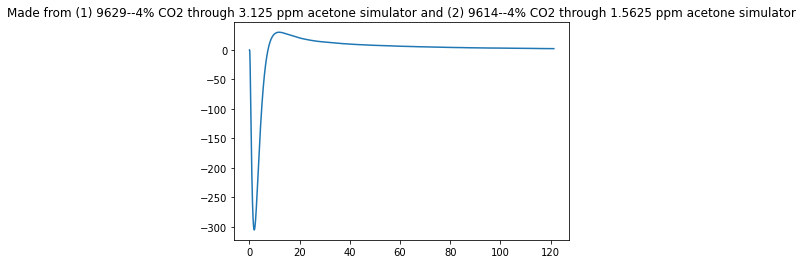

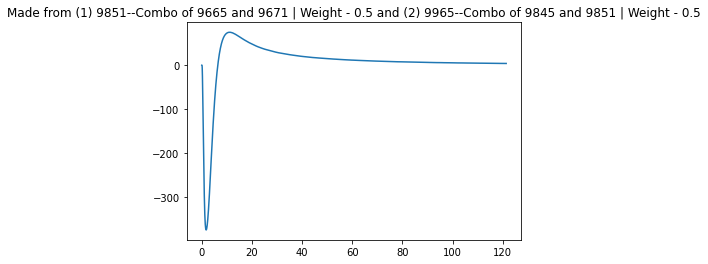

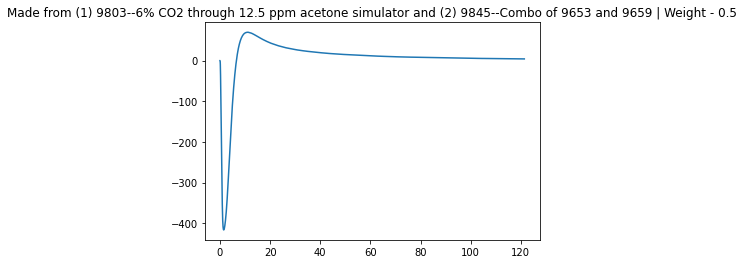

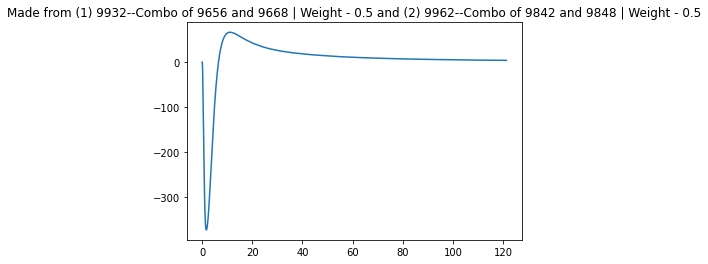

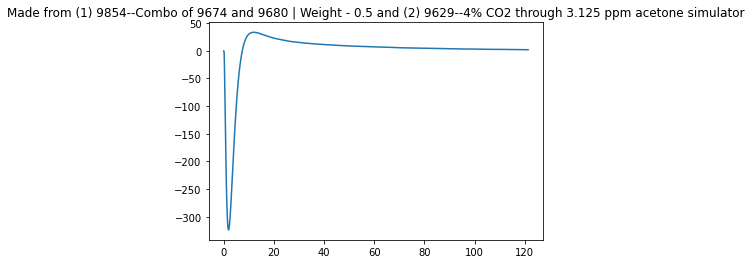

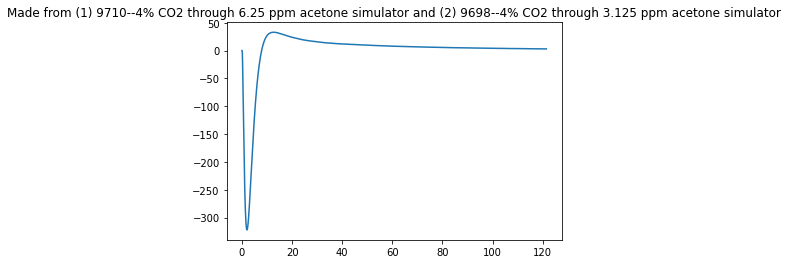

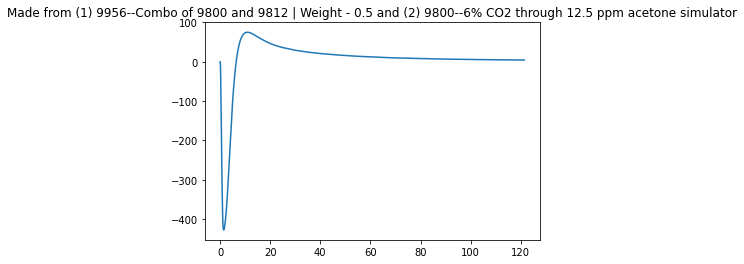

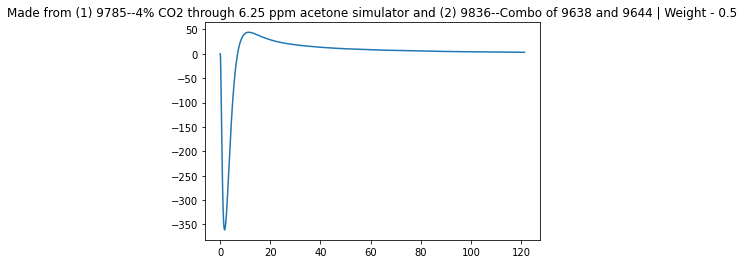

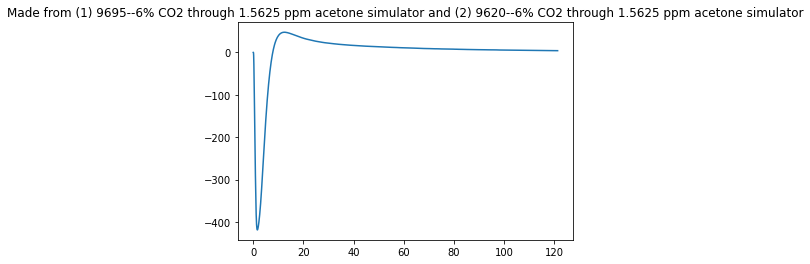

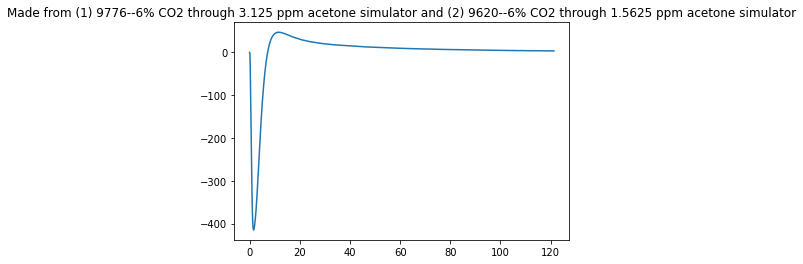

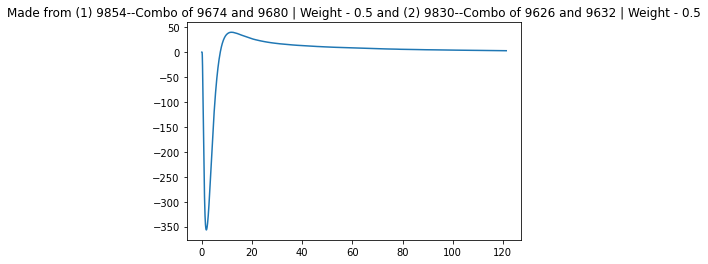

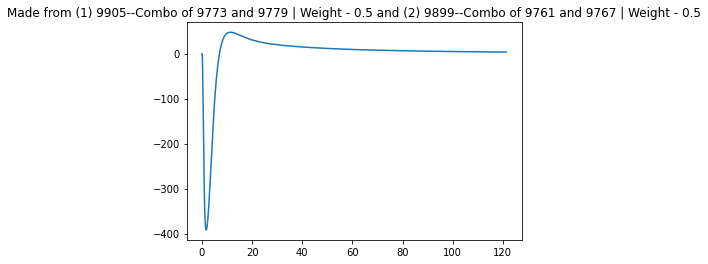

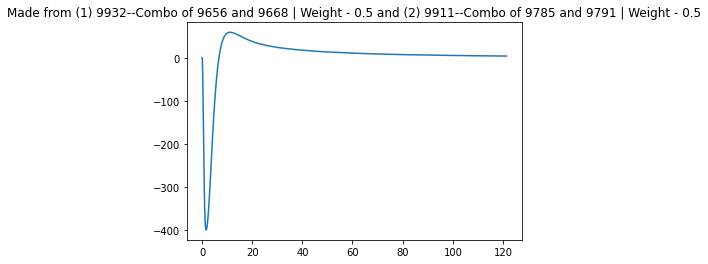

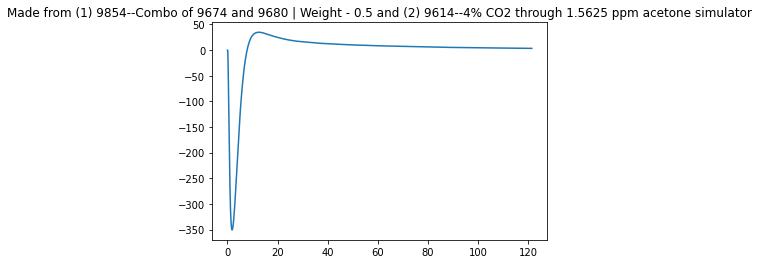

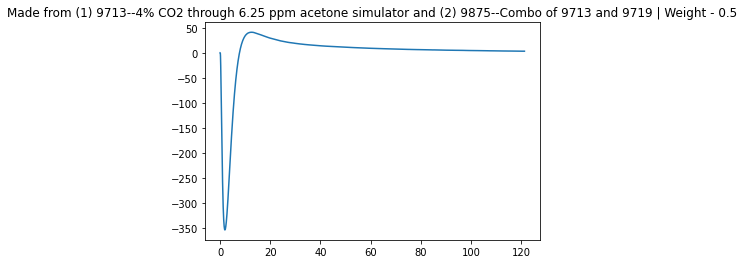

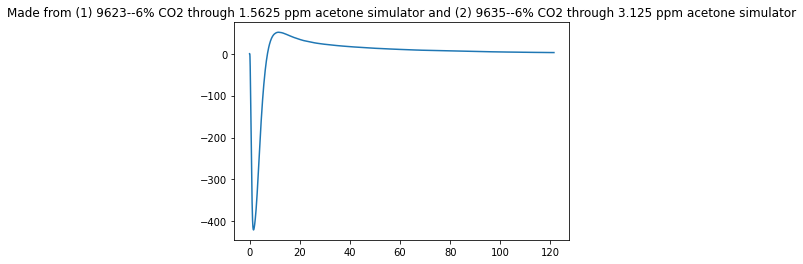

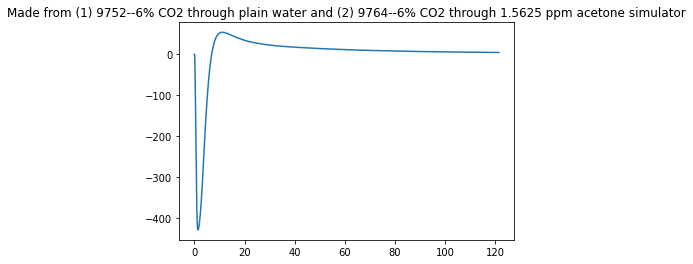

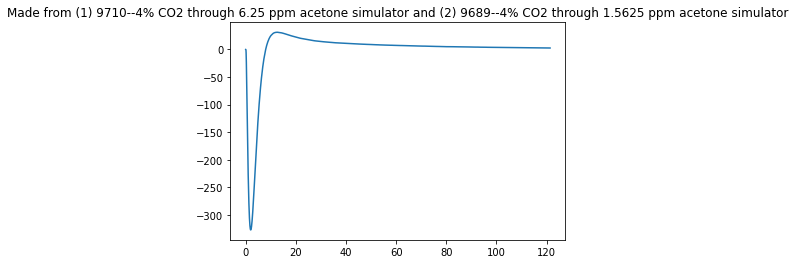

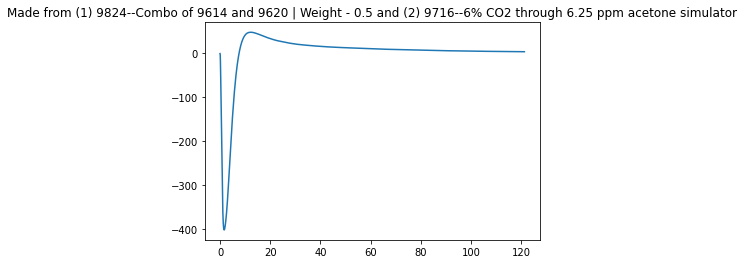

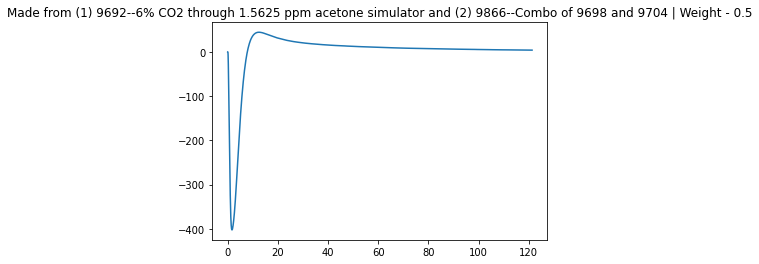

In [25]:
for test in test_list_16:
  signal = pd.read_csv(path  + '/test_output' + str(int(test)) + '.csv')
  test_name = fake_test_db_df.loc[test, 'Test_name']
  name, weights = test_name.split("|")
  c, o, t1, a, t2, s = name.split(" ")
  pt1 = test_db_df.loc[t1, 'Test_name']
  pt2 = test_db_df.loc[t2, 'Test_name']
  plt.plot(signal['Second'], signal['mV_rolling_mean'])
  plt.title('Made from (1) ' + str(t1) + '--' + pt1 + " and (2) " + str(t2) + '--' + pt2)
  plt.show()

